In [1]:
import os
os.environ["CALITP_BQ_MAX_BYTES"] = str(1_000_000_000_000) ## 1TB?

from calitp.tables import tbl
from calitp import query_sql

import pandas as pd
import geopandas as gpd
from siuba import *

import shared_utils

/opt/conda/lib/python3.10/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


# Read In / Transform MST Ridership Data

In [3]:
GCS_FILE_PATH = 'gs://calitp-analytics-data/data-analyses/ahsc_grant/'

In [4]:
yr_mst_raw = pd.read_excel(f'{GCS_FILE_PATH}MST Stop Level Data 9.1.21-8.31.22.xlsx')

In [5]:
yr_mst_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Stop_ID           2752 non-null   int64  
 1   Stop_Name         2752 non-null   object 
 2   Latitude          2752 non-null   float64
 3   Longitude         2752 non-null   float64
 4   Yearly_Boardings  2752 non-null   int64  
 5   Schedule          2752 non-null   object 
dtypes: float64(2), int64(2), object(2)
memory usage: 129.1+ KB


In [64]:
# stash id/name xwalk in environment - known dup name issue
mst_stopnames = (yr_mst_raw
                 >> distinct(_.Stop_ID,_.Stop_Name)
                 >> mutate(Stop_ID = _.Stop_ID.astype('int64').astype(str))
                 >> rename(stop_id = _.Stop_ID)
                )

In [72]:
day_cols = {'Weekday': 'weekday_ons', 'Saturday': 'sat_ons', 'Sunday': 'sun_ons'}

yr_mst_grouped = (yr_mst_raw
                 >> mutate(Stop_ID = _.Stop_ID.astype('int64').astype(str))
                 >> mutate(DAY_TYPE = _.Schedule.apply(lambda x: day_cols[x]))
                 >> group_by(_.Stop_ID, _.DAY_TYPE)
                 >> summarize(stop_total_ons = _.Yearly_Boardings.sum())
                )

In [73]:
yr_mst_grouped >> head(3)

,Stop_ID,DAY_TYPE,stop_total_ons
0,1001,sat_ons,112
1,1001,sun_ons,58
2,1001,weekday_ons,753


In [74]:
yr_mst_grouped = (yr_mst_grouped
                     >> spread("DAY_TYPE", "stop_total_ons")
                     >> rename(stop_id = _.Stop_ID)
                     >> mutate(calitp_itp_id = 208)
                    )

In [75]:
yr_mst_grouped >> head(3)

,stop_id,sat_ons,sun_ons,weekday_ons,calitp_itp_id
0,1001,112.0,58.0,753.0,208
1,1004,672.0,754.0,8534.0,208
2,1007,112.0,58.0,753.0,208


In [76]:
len(yr_mst_grouped)

974

In [69]:
# representative weekday in June - includes seasonal trolley service
mst_stops = shared_utils.gtfs_utils.get_stops('2022-06-01', [208])
len(mst_stops)

981

In [70]:
stops_to_join = mst_stops >> select(_.calitp_itp_id, _.stop_id, _.stop_name, _.geometry)

In [77]:
yr_mst_joined = stops_to_join >> inner_join(_, yr_mst_grouped, on = ['calitp_itp_id', 'stop_id'])

In [78]:
yr_mst_joined.info()

# just under 200 unmatched from both sides

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 796 entries, 0 to 795
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   calitp_itp_id  796 non-null    int64   
 1   stop_id        796 non-null    object  
 2   stop_name      796 non-null    object  
 3   geometry       796 non-null    geometry
 4   sat_ons        748 non-null    float64 
 5   sun_ons        749 non-null    float64 
 6   weekday_ons    787 non-null    float64 
dtypes: float64(3), geometry(1), int64(1), object(2)
memory usage: 49.8+ KB


In [79]:
stops_remainder = (stops_to_join 
    >> anti_join(_, yr_mst_grouped, on = ['calitp_itp_id', 'stop_id'])
                    )

len(stops_remainder)

185

In [80]:
yr_mst_remainder = (yr_mst_grouped 
    >> anti_join(_, stops_to_join, on = ['calitp_itp_id', 'stop_id'])
                    )


len(yr_mst_remainder)

178

Leading 0's issue

In [81]:
yr_mst_remainder = (yr_mst_remainder
                    >> mutate(stop_id = _.stop_id.apply(lambda x: x.zfill(4)))
                   )

In [82]:
# try join again
yr_mst_joined_zero = stops_remainder >> inner_join(_, yr_mst_remainder, on = ['calitp_itp_id', 'stop_id'])
yr_mst_joined_zero.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 163 entries, 0 to 162
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   calitp_itp_id  163 non-null    int64   
 1   stop_id        163 non-null    object  
 2   stop_name      163 non-null    object  
 3   geometry       163 non-null    geometry
 4   sat_ons        136 non-null    float64 
 5   sun_ons        136 non-null    float64 
 6   weekday_ons    163 non-null    float64 
dtypes: float64(3), geometry(1), int64(1), object(2)
memory usage: 10.2+ KB


In [83]:
# check out remainder not joined
stops_leftovers = stops_remainder >> anti_join(_, yr_mst_remainder, on = ['calitp_itp_id', 'stop_id'])
stops_leftovers

,calitp_itp_id,stop_id,stop_name,geometry
17,208,4720,Normandy / Carentan,POINT (-121.80736 36.63753)
99,208,2979,San Miguel Canyon Rd / #1347,POINT (-121.68591 36.84003)
126,208,1206,Ardennes / 2775 Ardennes,POINT (-121.80376 36.62893)
137,208,2935,San Miguel Canyon Rd / Woodland Hills,POINT (-121.68973 36.84516)
165,208,4710,Malmedy / Carentan,POINT (-121.80213 36.63990)
166,208,1200,Ardennes / Aachen Rd,POINT (-121.80957 36.63434)
186,208,2977,San Miguel Canyon Rd / #1335,POINT (-121.68942 36.84348)
246,208,4725,Normandy / Salerno,POINT (-121.81253 36.63780)
259,208,6954,Pvt Bolio Rd / Pvt Bolio Gate,POINT (-121.89929 36.60842)
331,208,2933,San Miguel Canyon Rd / # 1469,POINT (-121.68603 36.84020)


In [84]:
riders_leftovers = yr_mst_remainder >> anti_join(_, stops_remainder, on = ['calitp_itp_id', 'stop_id'])

In [85]:
riders_leftovers >> left_join(_,mst_stopnames)

,stop_id,sat_ons,sun_ons,weekday_ons,calitp_itp_id,Stop_Name
0,1101,0.0,0.0,251.0,208,INTERGARRISON/OTTERSPORTSCT
1,1101,0.0,0.0,251.0,208,INTERGARRISON/OTTERSPORTSCTR
2,1394,0.0,NaN,0.0,208,SCHILLING/COUNTYGOVERNMENTC
3,0493,NaN,NaN,0.0,208,NaN
4,7135,0.0,0.0,NaN,208,2NDAVE/8THSTREET
5,7137,0.0,0.0,NaN,208,2NDAVE/6THST
6,7139,0.0,0.0,NaN,208,2NDAVE/5THST
7,7140,224.0,0.0,251.0,208,2NDAVE/8THSTREET(NORTH)
8,7140,224.0,0.0,251.0,208,2NDAVE/8THSTREET
9,7144,0.0,0.0,NaN,208,2NDAVE/6THST


In [90]:
# set tables together
gdfs = [yr_mst_joined_zero,yr_mst_joined]

yr_mst_geo_all = pd.concat(gdfs, ignore_index=True)

yr_mst_geo_all

,calitp_itp_id,stop_id,stop_name,geometry,sat_ons,sun_ons,weekday_ons
0,208,0633,Hilby / Mescal,POINT (-121.82737 36.60219),0.0,0.0,251.0
1,208,0446,Carmel Valley Rd / Boronda,POINT (-121.74623 36.49383),56.0,0.0,251.0
2,208,0231,Ocean View / Moss,POINT (-121.92068 36.62763),0.0,0.0,251.0
3,208,0004,Del Monte Center / Gate 3,POINT (-121.89893 36.58445),56.0,58.0,502.0
4,208,0465,Carmel Valley Rd / Loma Del Rey,POINT (-121.81701 36.52727),0.0,0.0,0.0
...,...,...,...,...,...,...,...
954,208,2286,Munras / N. Del Monte Center,POINT (-121.89982 36.58644),112.0,58.0,251.0
955,208,6918,W Franklin / Van Buren,POINT (-121.89772 36.60071),NaN,NaN,0.0
956,208,2392,Front / San Vicente,POINT (-121.33432 36.43021),392.0,406.0,8283.0
957,208,5022,Lighthouse / 17th,POINT (-121.91895 36.62151),168.0,116.0,1506.0


In [91]:
# fill nan with 0
values = {"sat_ons": 0, "sun_ons": 0, "weekday_ons": 0}
yr_mst_geo_all = yr_mst_geo_all.fillna(value=values)

In [92]:
# check 0s
mst_0check = (yr_mst_geo_all >>
                    filter(_.weekday_ons==0)
                   )
mst_0check.explore("weekday_ons", legend=True)

/opt/conda/lib/python3.10/site-packages/mapclassify/classifiers.py:891: RuntimeWarning: invalid value encountered in double_scalars


In [93]:
shared_utils.utils.geoparquet_gcs_export(yr_mst_geo_all, GCS_FILE_PATH, 'rider_cleaned_208_2021_09_to_2022_08.parquet')

## Exploratory Data Analysis

In [94]:
# weekday ons map
yr_mst_geo_all.explore("weekday_ons", legend=True, tiles="CartoDB positron")

Text(0, 0.5, 'Number of Stops')

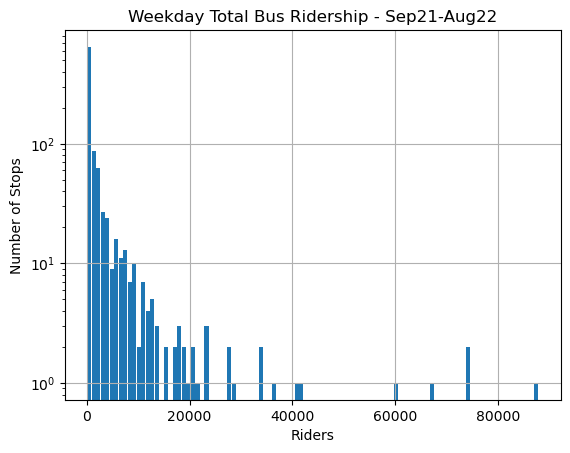

In [95]:
import matplotlib.pyplot as plt

yr_mst_geo_all.weekday_ons.plot.hist(grid=True, bins=100, rwidth=0.9, log=True,
                                          title='Weekday Total Bus Ridership - Sep21-Aug22')
plt.xlabel('Riders')
plt.ylabel('Number of Stops')

In [96]:
yr_mst_geo_all >> filter(_.weekday_ons>40000)

,calitp_itp_id,stop_id,stop_name,geometry,sat_ons,sun_ons,weekday_ons
118,208,0011,Northridge Mall,POINT (-121.65803 36.71563),9128.0,13224.0,40662.0
260,208,9205,Salinas Transit Center / Gate 5,POINT (-121.65701 36.67622),4032.0,4640.0,41415.0
560,208,9102,Monterey Transit Plaza / Gate 2 Munras,POINT (-121.89444 36.59724),5880.0,6496.0,87850.0
602,208,1603,Cannery Row / Prescott,POINT (-121.90008 36.61582),22624.0,22562.0,74296.0
632,208,5460,Playa / Sand City Station,POINT (-121.84377 36.61930),8904.0,8178.0,67268.0
858,208,9104,Monterey Transit Plaza / Gate 4 Tyler,POINT (-121.89416 36.59749),9352.0,8932.0,60491.0
908,208,1616,Cannery Row / Aquarium,POINT (-121.90153 36.61758),28952.0,31204.0,74045.0
